In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing

In [14]:
my_path = "C:/Users/user/lighthouse/Midterm_Project/Predicting_Flight_Delays/workbench/data/"
df = pd.read_csv(my_path +'flights.csv')
df.head()

,fl_date,mkt_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,carrier,month,day_of_week,haul_length,route,flight_delayed
0,2018-05-04,DL,N754EV,BOS,"Boston, MA",RIC,"Richmond, VA",1455,1453.0,-2.0,...,0.0,0.0,0.0,0.0,Delta Air Lines,5,4,short,BOS-RIC,0
1,2019-12-09,UA,N828UA,MSY,"New Orleans, LA",EWR,"Newark, NJ",1515,1757.0,162.0,...,0.0,178.0,0.0,0.0,United Airlines,12,0,short,MSY-EWR,1
2,2019-12-20,AA,N763US,CLT,"Charlotte, NC",SAT,"San Antonio, TX",1610,1630.0,20.0,...,0.0,0.0,0.0,0.0,American Airlines,12,4,short,CLT-SAT,1
3,2019-07-14,DL,N961DL,ATL,"Atlanta, GA",PWM,"Portland, ME",2114,2114.0,0.0,...,0.0,0.0,0.0,0.0,Delta Air Lines,7,6,short,ATL-PWM,0
4,2019-04-08,AA,N679AW,PHX,"Phoenix, AZ",BOI,"Boise, ID",2021,2015.0,-6.0,...,0.0,0.0,0.0,0.0,American Airlines,4,0,short,PHX-BOI,0


In [15]:
categorical_features = [i for i in df.columns if df[i].dtypes=='O']
cat_df = df[categorical_features]
# cat_df.head()

In [16]:
df['dest']=LabelEncoder().fit_transform(df.dest)
df['origin']=LabelEncoder().fit_transform(df.origin)
df['carrier_encoded']=LabelEncoder().fit_transform(df.mkt_unique_carrier)
df['route']=LabelEncoder().fit_transform(df.route)
df['haul_encoded']=LabelEncoder().fit_transform(df.haul_length)
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400]
df['binned_dep'] = np.searchsorted(bins, df['crs_dep_time'].values)
df['binned_arr'] = np.searchsorted(bins, df['crs_arr_time'].values)
bins = [0, 1100, 4100, 10000]
df['binned_distance'] = np.searchsorted(bins, df['distance'].values)

In [17]:
numeric_features = [i for i in df.columns if df[i].dtypes!='O']
print(numeric_features)
num_df = df[numeric_features]
num_df.head()

['origin', 'dest', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'month', 'day_of_week', 'route', 'flight_delayed', 'carrier_encoded', 'haul_encoded', 'binned_dep', 'binned_arr', 'binned_distance']


,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,...,late_aircraft_delay,month,day_of_week,route,flight_delayed,carrier_encoded,haul_encoded,binned_dep,binned_arr,binned_distance
0,46,297,1455,1453.0,-2.0,20.0,1513.0,1631.0,4.0,1649,...,0.0,5,4,672,0,3,2,5,6,1
1,243,117,1515,1757.0,162.0,38.0,1835.0,2151.0,10.0,1903,...,0.0,12,0,3978,1,8,2,6,7,2
2,73,308,1610,1630.0,20.0,16.0,1646.0,1837.0,4.0,1822,...,0.0,12,4,1092,1,0,2,6,7,1
3,21,290,2114,2114.0,0.0,12.0,2126.0,2339.0,2.0,2355,...,0.0,7,6,255,0,3,2,8,8,1
4,271,44,2021,2015.0,-6.0,16.0,2031.0,2312.0,4.0,2330,...,0.0,4,0,4671,0,0,2,7,8,1


In [18]:
final_num_df = num_df.copy()
final_num_df = final_num_df.filter(['origin', 'dest','taxi_out', 'taxi_in','month','day_of_week', 'carrier_encoded', 
                                    'haul_encoded', 'binned_dep', 'binned_arr', 'binned_distance', 'route','arr_delay'])

In [19]:
final_num_df.head()

,origin,dest,taxi_out,taxi_in,month,day_of_week,carrier_encoded,haul_encoded,binned_dep,binned_arr,binned_distance,route,arr_delay
0,46,297,20.0,4.0,5,4,3,2,5,6,1,672,-14.0
1,243,117,38.0,10.0,12,0,8,2,6,7,2,3978,178.0
2,73,308,16.0,4.0,12,4,0,2,6,7,1,1092,19.0
3,21,290,12.0,2.0,7,6,3,2,8,8,1,255,-14.0
4,271,44,16.0,4.0,4,0,0,2,7,8,1,4671,-14.0


In [20]:
final_num_df.to_csv('feature_1.csv')

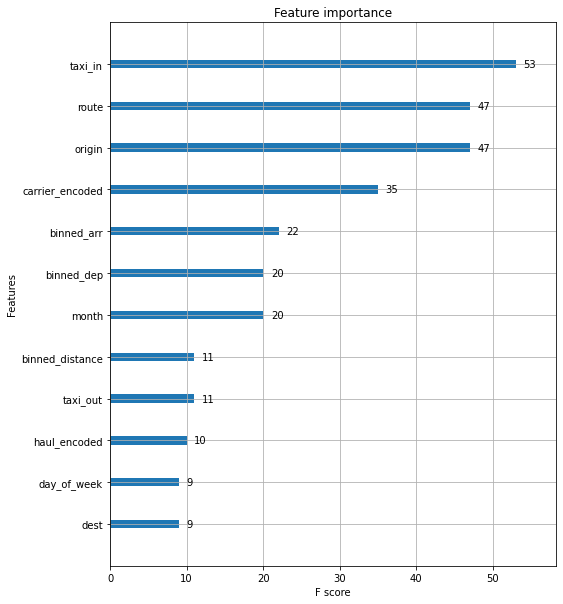

In [42]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()